<a href="https://colab.research.google.com/github/sling1678/ML_programs_for_video_lectures/blob/main/iris.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Iris Classification Problem

## Problem Statement: Given petal length, petal width, sepal length, and sepal width, can you tell whether the iris is setosa, virginica, or versicolor?

## Making use of already existing example PyTorch code.
###The quickstart example at the following website can be adapted to the iris classification problem with ease. 
https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html

### The data has 150 samples of setosa, virginica, or versicolor, each equally represented. You are tasked to use this data to build and test any statistical model. Your model should predict conditional probability, Prob(type=setosa|given pl,pw,sl,sw),  Prob(type=virginica|given pl,pw,sl,sw), and Prob(type=versicolor|given pl,pw,sl,sw).
### The model presented here 

I will illustrate a feedforward neural network that has a single hiddlen layer with $n_h$ hidden neurons and an output layer with three neurons for the three classes corresponding to the thre iris types. Therefore, the network will have two weight matrices to learn the composite function:
$$
g( f\left( X*W_1\right) * W2 ),
$$
where $X$ is $[1,x_1, x_2, x_3, x_4]$, the extended 4-dimensional vector data, here. For $f$, we choose the ReLU unit. For $g$, we choose softmax to convert the argument of $g$ to probabiliy.

The arbitrariness in decisions are (1) number of neuron units in the hidden layer and (2) the activation function ReLU used for nonlinearity, (3) the learning rate, (4) number of epochs to train, (5) batch size to use. I do not attempt to correct for overfitting since this program is elementary and for illustrative purposes only.

## THE IMPORTS

In [1]:
#IMPORTS, device choice, and debugging mode
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm # to use for progress bar

import torch as T
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
device = (
    "cuda" if T.cuda.is_available()
    else "mps" if T.backends.mps.is_available()
    else "cpu"
) #Note: MPS stands for Metal Performance Shaders backend for GPU training acceleration that PyTorch uses.

In [2]:
# Make sure you are using the python and pytorch versions I used to run this program
assert int(T.__version__.split('.')[0]) >= 2, "Use PyTorch v 2.0 or more recent"
import sys
assert sys.version_info >= (3, 10), "Use Python 3.10 or newer"

## THE DEBUG FLAG

In [3]:
# Set this to False to just run the final simulation
DEBUG = False
#---------------Check this panel and all above it -----
if DEBUG:
  print(f"Device we are using is {device}")

## DATA COLLECTION AND PREPARARATION

In [4]:
# DATA COLLECTION AND DATA PREPROCESSING
iris = load_iris()
def shuffle_downloaded_data_and_set_aside_test_data(iris, test_size=0.25, verbose=True):
  X = iris['data']
  Y = iris['target']
  target_names = iris['target_names']
  feature_names = iris['feature_names']

  # randomly shuffle the data
  Z = np.concatenate((X, Y[:,None]),axis=1)
  if verbose:
    print(f"Check if X and y are concatenated : {Z[:3,:]}")
  np.random.shuffle(Z)
  if verbose:
    print(f"Check if data is shuffled compared to above : {Z[:3,:]}")
  X, y = Z[:,:-1], Z[:,-1]
  if verbose:
    print(f"Check if X and y got properly separated {X[:3]}, {y[:3]}")
  # SET ASIDE A TEST SET - NEVER LOOK INSIDE THAT DATA ***
  X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, random_state=42)
  if verbose:
    print(f"X_train.shape = {X_train.shape}, y_train.shape = {y_train.shape}, "+
        f"X_test.shape = {X_test.shape}, y_test.shape = {y_test.shape}")
  return X_train, y_train, X_test, y_test, target_names, feature_names

def preprocess_data(X_train, y_train, X_test=None, y_test=None, verbose=True):
  # We scale the X data to have mean 0 and variance 1 by using the X_train
  scaler = StandardScaler()
  scaler.fit(X_train) # this extracts parameters of scaler from X_train
  X_train = scaler.transform(X_train)
  if X_test is not None:
    X_test = scaler.transform(X_test)
  scaler.get_params
  if verbose:
    print(f"Preprocess params: mean = {scaler.mean_}, var = {scaler.var_}")
  return X_train, y_train, X_test, y_test



#---------------Check this panel and all above it -----
if DEBUG:
  X_train, y_train, X_test, y_test, target_names, feature_names =\
    shuffle_downloaded_data_and_set_aside_test_data(iris, test_size=0.25)
  X_train, y_train, X_test, y_test = preprocess_data(X_train, y_train, X_test, y_test)

## DATA VISUALIZATION

Check if X and y are concatenated : [[5.1 3.5 1.4 0.2 0. ]
 [4.9 3.  1.4 0.2 0. ]
 [4.7 3.2 1.3 0.2 0. ]]
Check if data is shuffled compared to above : [[4.4 3.  1.3 0.2 0. ]
 [5.9 3.  5.1 1.8 2. ]
 [7.2 3.  5.8 1.6 2. ]]
Check if X and y got properly separated [[4.4 3.  1.3 0.2]
 [5.9 3.  5.1 1.8]
 [7.2 3.  5.8 1.6]], [0. 2. 2.]
X_train.shape = (112, 4), y_train.shape = (112,), X_test.shape = (38, 4), y_test.shape = (38,)


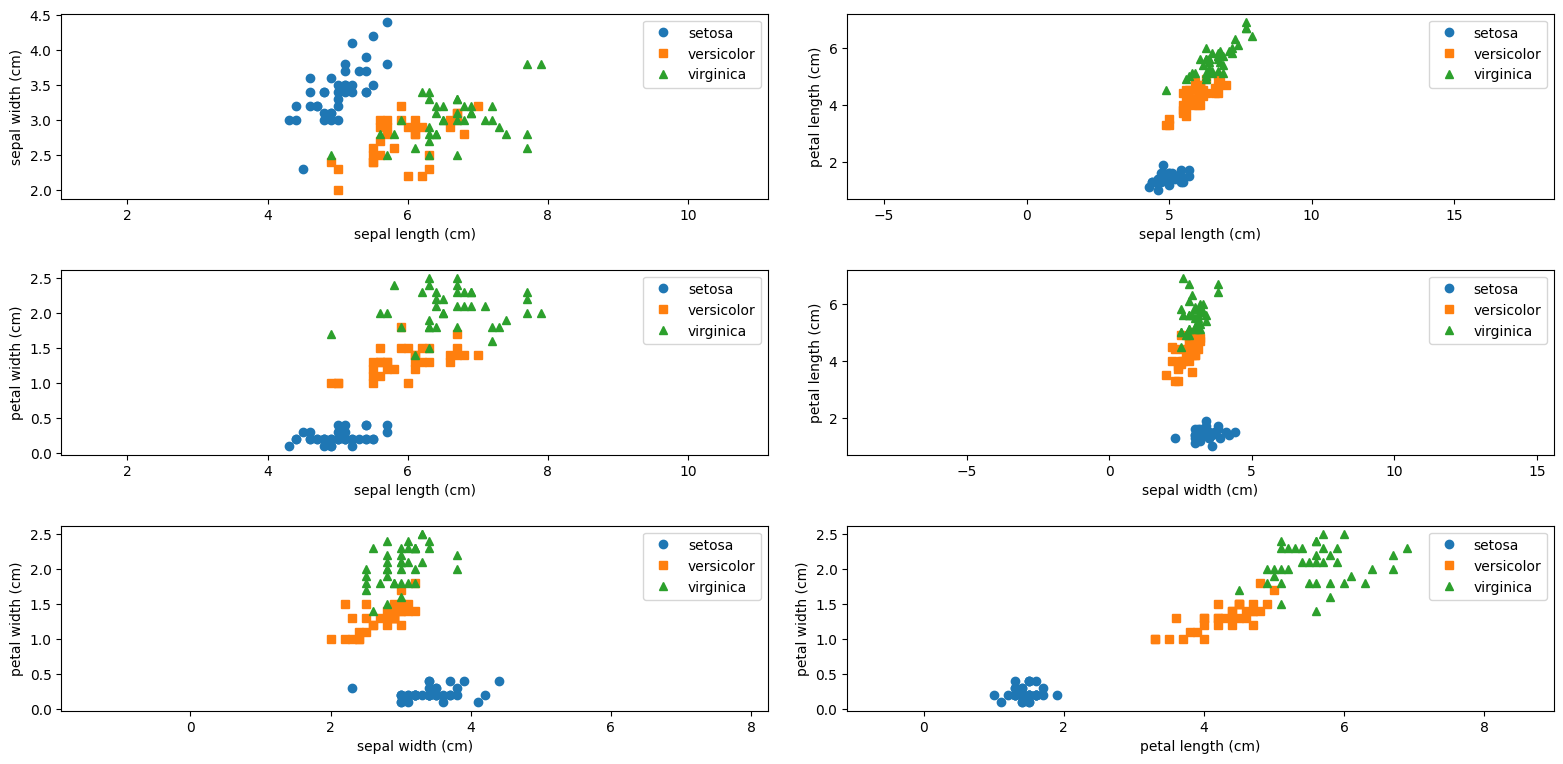

In [5]:
# VISUALIZE THE DATA TO GAIN INSIGHT

def make_plots(X, Y, names, savefile="iris-pairplots.png"):
  """
  This function makes pair plots for the three types and displays them.
  You can see in which plane the data appears to be separable.
  """

  fig, ax = plt.subplots(3, 2, figsize=(16, 8))

  feature_pairs = [([0,1], [0,2]), ([0,3], [1,2]), ([1,3], [2,3])]
  def plotone(fig, ax, X, Y, names, features):
    markers=['o', 's', '^']
    for index, target_name in enumerate(names):
      X_plot = X[Y == index]
      ax.plot(X_plot[:, features[0]], X_plot[:, features[1]], 
              linestyle='none', 
              marker= markers[index], 
              label=target_name)
    ax.set_xlabel(feature_names[features[0]])
    ax.set_ylabel(feature_names[features[1]])
    ax.axis('equal')
    ax.legend();
  
  for i, (ax1, ax2) in  enumerate(ax): # plot each row of plots
    pair1, pair2 = feature_pairs[i]
    plotone(fig, ax1, X, Y, names, features=pair1)
    plotone(fig, ax2, X, Y, names, features=pair2)

  fig.tight_layout(pad=2.0)
  plt.savefig(savefile)
  plt.show()

# check this panel
if True:
  X_train, y_train, X_test, y_test, target_names, feature_names =\
    shuffle_downloaded_data_and_set_aside_test_data(iris, test_size=0.25)
  make_plots(X_train, y_train, target_names) # you better never look inside X_test and y_test


## CREATE DATALOADERS FOR USE IN PYTORCH MODELS

In [6]:
# DATALOADERS FOR USE IN PYTORCH MODELS
def prepare_dataloaders(X_train, y_train, X_test=None, y_test=None, batch_size=8, verbose=True):

  train_ds = TensorDataset(T.Tensor(X_train), T.Tensor(y_train).to(T.int64))
  train_loader = DataLoader(train_ds , batch_size = batch_size, shuffle=True)
  
  if X_test is not None and y_test is not None:
    test_ds = TensorDataset(T.Tensor(X_test), T.Tensor(y_test).to(T.int64))
    test_loader = DataLoader(test_ds , batch_size = batch_size, shuffle=False)
  else:
    test_loader = None

  if verbose:
    for X, y in train_loader:
      print(f"Shape of X_train : {X.shape} should be [batch_size, features]")
      print(f"Shape and dtype of y_test : {y.shape} {y.dtype} should be [batch_size], int64")
      break
  return train_loader, test_loader


def get_and_process_data_into_dataloaders(test_size=0.25, batch_size=8, verbose=True):
  # Package all requisite functions into one function that yields the dataloaders
  iris = load_iris()
  X_train, y_train, X_test, y_test, target_names, feature_names =\
    shuffle_downloaded_data_and_set_aside_test_data(iris, test_size=test_size, verbose=verbose)
  X_train, y_train, X_test, y_test = preprocess_data(X_train, y_train, X_test, y_test, verbose=verbose)
  train_loader, test_loader = prepare_dataloaders(X_train, y_train, X_test, y_test, batch_size=batch_size, verbose=verbose)
  return train_loader, test_loader
#---------------Check this panel and all above it -----
if DEBUG:
  train_loader, test_loader = prepare_dataloaders(X_train, y_train, X_test, y_test)

## DEFINE MODEL

In [7]:
# Define model
class NeuralNetwork(T.nn.Module):
  """
  Our example netwrok has only one hidden layer. 
  We will need to supply the number of units in that layer to initialize 
  an instance of this model.
  """
  def __init__(self, hidden_units):
    super(NeuralNetwork, self).__init__() 
    self.hidden = T.nn.Linear(4, hidden_units)  
    self.output = T.nn.Linear(hidden_units, 3)

    # initialize parameters
    T.nn.init.xavier_uniform_(self.hidden.weight)
    T.nn.init.zeros_(self.hidden.bias)
    T.nn.init.xavier_uniform_(self.output.weight)
    T.nn.init.zeros_(self.output.bias)

  def forward(self, x):
    z = T.relu(self.hidden(x))
    z = self.output(z) # output the logits
    return z
#---------------Check this panel and all above it -----
if DEBUG:
  model = NeuralNetwork(hidden_units).to(device)
  print(f"Model architecture: {model}")
  for X,y in train_loader:
    print("The logits output of three samples from one batch")
    print(model(X)[:3])
    break

## THE TRAINING LOOP CALCULATIONS

In [8]:
# Define Training Loop
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()

    train_loss = 0
    for batch, (X, y) in enumerate(dataloader):
        num_in_this_batch = len(X)
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad() # after updating weights, need to reset the optimizer

        # Record the loss
        train_loss += loss.item() * num_in_this_batch
    train_loss /= size

    return train_loss


## TESTING THE TRAINED MODEL AFTER EPOCHS

In [9]:
# TEST
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with T.no_grad():
        for X, y in dataloader:
            num_in_this_batch = len(X)
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss = loss_fn(pred, y)
            test_loss += loss.item() * num_in_this_batch
            correct += (pred.argmax(1) == y).type(T.float).sum().item()
    test_loss /= size
    correct /= size
    return test_loss, correct

## FINAL FUNCTION TO RUN THE SIMULATION

100%|██████████| 201/201 [00:08<00:00, 22.46it/s]


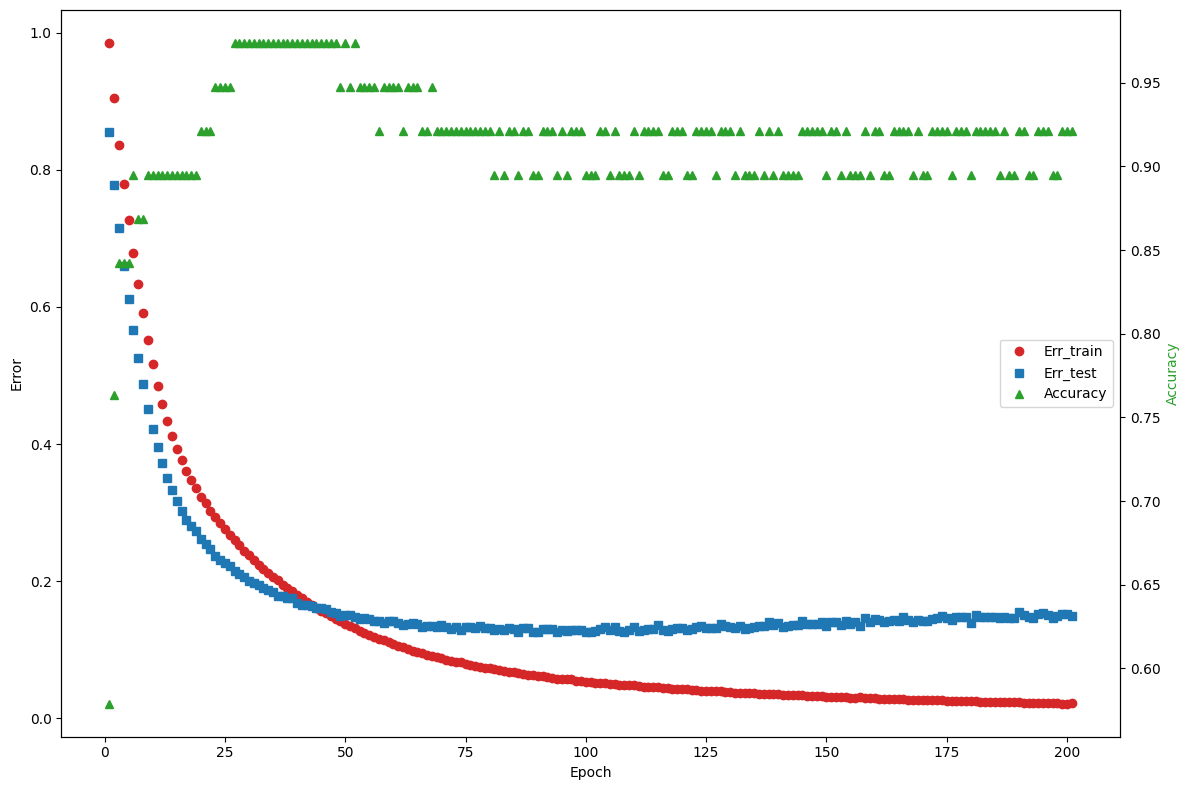

In [10]:
# RUN
hyperparams = dict()
hyperparams['learning_rate'] = 1e-3
hyperparams['layer_units'] = [32]
hyperparams['batch_size'] = 8
hyperparams['epochs'] = 200
learning_rate = hyperparams['learning_rate']
hidden_units = hyperparams['layer_units'][0]
batch_size = hyperparams['batch_size']
epochs =  hyperparams['epochs']

def run_simulation(hyperparams, write_nepochs=20, test_size=0.25, verbose=True):
  # Get and process data
  train_loader, test_loader = get_and_process_data_into_dataloaders(\
      test_size=test_size, batch_size=hyperparams['batch_size'], verbose=verbose)
  # get an instance of model
  model = NeuralNetwork(hyperparams['layer_units'][0]).to(device)
  # Pick LOSS AND OPTIMZER; LOSS FUNCTION will be nn.CrossEntropyLoss() 
  loss_fn = nn.CrossEntropyLoss()
  optimizer = T.optim.Adam(model.parameters(), lr=hyperparams['learning_rate'])
  
  # results collectors
  err_in=[] # training loss
  err_out=[] # test loss
  acc = [] # test accuracy

  for t in tqdm(range(hyperparams['epochs']+1)):
      train_loss = train(train_loader, model, loss_fn, optimizer)
      err_in.append((t+1, train_loss))
      if test_loader is not None:
        test_loss, correct = test(test_loader, model, loss_fn)
        err_out.append((t+1, test_loss))
        acc.append((t+1, correct ))
      if verbose:
        if t%write_nepochs == 0:
          print(f"Epoch {t+1}: train_loss = {train_loss:>7f},"+
                f"test_loss = {test_loss:>7f}, Accuracy: {(100*correct):>0.1f}%")

  return err_in, err_out, acc, model

def plot_results(err_in, err_out, acc, save=True):

  # extract [x,y] for three plots
  err_train = []
  err_test = []
  acc_test = []
  for elem in err_in:
    #err_train.append([elem[0], elem[1].detach().numpy()])
    err_train.append([elem[0], elem[1]])
  for elem in err_out:
    err_test.append([elem[0], elem[1]])
  for elem in acc:
    acc_test.append([elem[0], elem[1]])

  ep = [a for a,b in err_train]
  ein = [b for a,b in err_train]
  eout = [b for a,b in err_test]
  acc = [b for a,b in acc_test]

  # set up figure and axes

  fig, ax1 = plt.subplots(1, 1, figsize=(12, 8))

  markers=['o', 's', '^']
  p1 = ax1.plot(ep, ein, 
    linestyle='none', color='tab:red', marker= markers[0], label='Err_train')
  p2 = ax1.plot(ep, eout, 
    linestyle='none', color='tab:blue', marker= markers[1], label='Err_test')
  
  ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
  p3 = ax2.plot(ep, acc, 
    linestyle='none', color='tab:green', marker= markers[2], label='Accuracy')    
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('Error')
  ax2.set_ylabel('Accuracy', color='tab:green')
  #ax.axis('equal')
  
  plots = p1+p2+p3
  labels = [p.get_label() for p in plots]
  ax1.legend(plots, labels, loc='center right')

  fig.tight_layout()  # otherwise the right y-label is slightly clipped
  if save:
    import time
    timestr = time.strftime("%Y%m%d-%H%M%S")
    plt.savefig(f"iris-errors-accuracy-{timestr}.png")
  plt.show()



#--------------------
err_in, err_out, acc, model = run_simulation(hyperparams, verbose=False)
plot_results(err_in, err_out, acc, save=True)